In [314]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datenspende.utils import query_ch_df, query_pg_df
import datetime
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import os
import glob

In [116]:
lc_u = np.load('uid_per_shb_fatigue.npy')
lc_u2=np.load('uid_per_shb_fatigue(1).npy')

In [117]:
path = os.getcwd()+'/user_df/'
csv_files = glob.glob(os.path.join(path, "*.csv"))

df_lcu = []
demo_info = []
uid = []
for f in csv_files:
      
    # read the csv file
    df = pd.read_csv(f, index_col = 0)
    for var in ['sleep', 'hr', 'steps']:
        if var not in df.columns:
            df[var] = np.nan
    df_lcu.append(df)
    demo_info.append(f.split("/")[-1].split('.')[0])
    uid.append(int(f.split("/")[-1].split('.')[1][1:])) 
      
sex = [re.split('(\d+)',demo_info[i])[0] for i in range(len(demo_info))]
age = [int(re.split('(\d+)',demo_info[i])[1]) for i in range(len(demo_info))] 

df_lcu.pop(31)
uid.pop(31)
sex.pop(31)
age.pop(31)
df_lcu.pop(67)
uid.pop(67)
sex.pop(67)
age.pop(67)

60

In [310]:
uid[22]

146789

In [118]:
df = df_lcu[22] 
df['dt'] = pd.to_datetime(df['dt'])
df['date'] = pd.to_datetime(df['date'])

In [119]:
df.head()

,date,Time Bin 1,steps,hr,sleep,day_of_week,weekend,dt,week_totest,time,phase,d to max hr [%]
0,2021-05-09,"[0, 1)",NaN,NaN,NaN,6,True,2022-03-21,-45,0,0,NaN
1,2021-05-09,"[1, 2)",NaN,NaN,NaN,6,True,2022-03-21,-45,1,0,NaN
2,2021-05-09,"[2, 3)",NaN,NaN,NaN,6,True,2022-03-21,-45,2,0,NaN
3,2021-05-09,"[3, 4)",NaN,NaN,NaN,6,True,2022-03-21,-45,3,0,NaN
4,2021-05-09,"[4, 5)",NaN,NaN,NaN,6,True,2022-03-21,-45,4,0,NaN


In [120]:
mis_row = []
for dt in [d for d in pd.date_range(start = df['date'].min(), end = df['date'].max()).difference(df.index) if d not in df['date'].unique()]:
    mis_row.append([
            dt, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])

In [121]:
df = df.append(pd.DataFrame(data=mis_row, columns=df.columns))

In [122]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

In [123]:
# d = dataframe of rolling 7 days
def get_rss(d):
    night = d[(d['time'] < 29)&(d['steps'].isna())]['hr'].dropna()
    day = d[(d['time'] >= 29)&(d['steps'].notna())]['hr'].dropna()
    if len(night) > 0 and len(day) > 0:
        x = np.percentile(night, list(range(0,100)))
        y = np.percentile(day, list(range(0,100)))
        return sum((x - y)**2)
    else:
        return np.nan
    

In [124]:
def sliding_window(elements, window_size):
    wi_days = []
    for i in range(len(elements)- window_size + 1):
         wi_days.append(elements[i:i+window_size])
    return wi_days

In [125]:
wi_list = sliding_window(df['date'].unique(),21)
rsss = []
for wi in wi_list:
    rsss.append(get_rss(df[df['date'].isin(wi)]))
    

In [126]:
# plt.plot(range(len(rsss)), rsss) 
# dd = df.groupby('date').sum()
# plt.plot(10*list(np.where(dd.index == df['dt'].iloc[0])[0] ), np.linspace(0,max(rsss),10),c='r');

In [303]:
def get_ov(subd, bins):
    
    night = subd[(subd['time'] < 29)&(subd['steps'].isna())]['hr'].dropna()
    day = subd[(subd['time'] >= 29)&(subd['steps'].notna())]['hr'].dropna()
    n_d, _ = np.histogram(day, bins=bins)
    n_n, _ = np.histogram(night, bins=bins)
    d = n_d/len(day)
    n = n_n/len(night)
    #if np.isnan(np.sum(np.minimum(n,d))):
    #    ov = 0
    if len(day) >= 100 and len(night) >= 100:
        ov = np.sum(np.minimum(n,d))#np.round(np.sum(np.minimum(n,d)),2)
    else:
        ov = -1
    return ov,len(day), len(night)

In [311]:
binwidth = 40

bins=np.linspace(df['hr'].min(), df['hr'].max() + (binwidth/2), binwidth)
wi_list = sliding_window(df['date'].unique(),14)
ovs = []
day_d = []
night_d = []
for wi in wi_list:
    over, d, n = get_ov(df[df['date'].isin(wi)], bins)
    ovs.append(over)
    day_d.append(d)
    night_d.append(n)

/tmp/ipykernel_63/314206398.py:7: RuntimeWarning: invalid value encountered in divide
  d = n_d/len(day)
/tmp/ipykernel_63/314206398.py:8: RuntimeWarning: invalid value encountered in divide
  n = n_n/len(night)


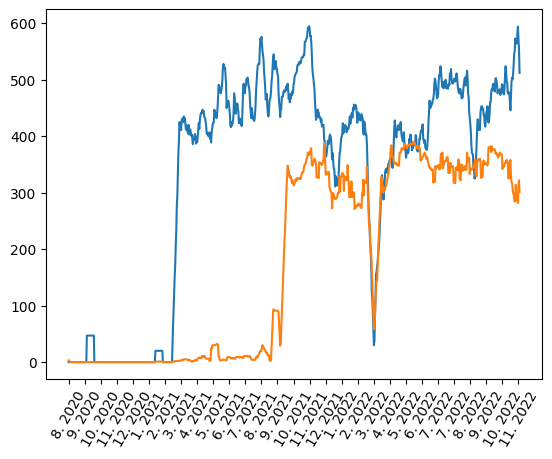

In [312]:
plt.plot(range(len(day_d)), day_d)
plt.plot(range(len(night_d)), night_d)
plt.xticks(range(len(ovs))[::30],labels = [str(pd.to_datetime(w[0]).month)+'. '+str(pd.to_datetime(w[0]).year) for w in wi_list][::30],rotation=60);

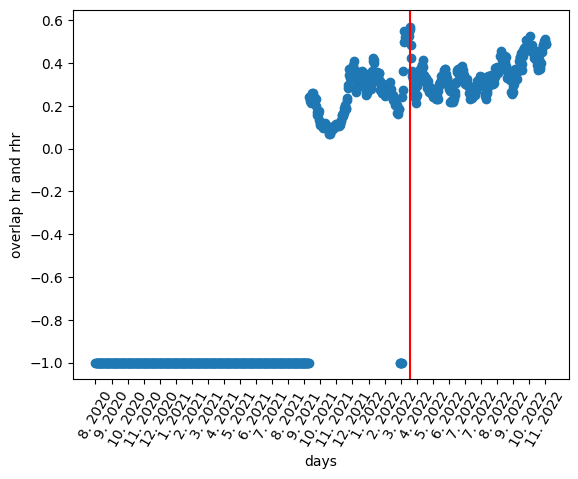

In [313]:
plt.scatter(range(len(ovs)),ovs)
dd = df.groupby('date').sum()

plt.axvline(x=np.where(dd.index == df['dt'].iloc[0])[0] ,color='r')
plt.xticks(range(len(ovs))[::30],labels = [str(pd.to_datetime(w[0]).month)+'. '+str(pd.to_datetime(w[0]).year) for w in wi_list][::30],rotation=60)
plt.xlabel('days')
plt.ylabel('overlap hr and rhr');

(206.0, 220.0)

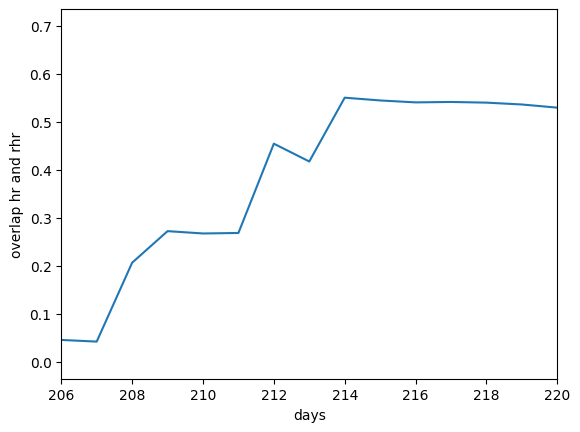

In [283]:
plt.plot(range(len(ovs)),ovs)
dd = df.groupby('date').sum()
plt.plot(10*list(np.where(dd.index == df['dt'].iloc[0])[0] ), np.linspace(0,max(ovs),10))
plt.xlabel('days')
plt.ylabel('overlap hr and rhr');
plt.xlim(206,220)

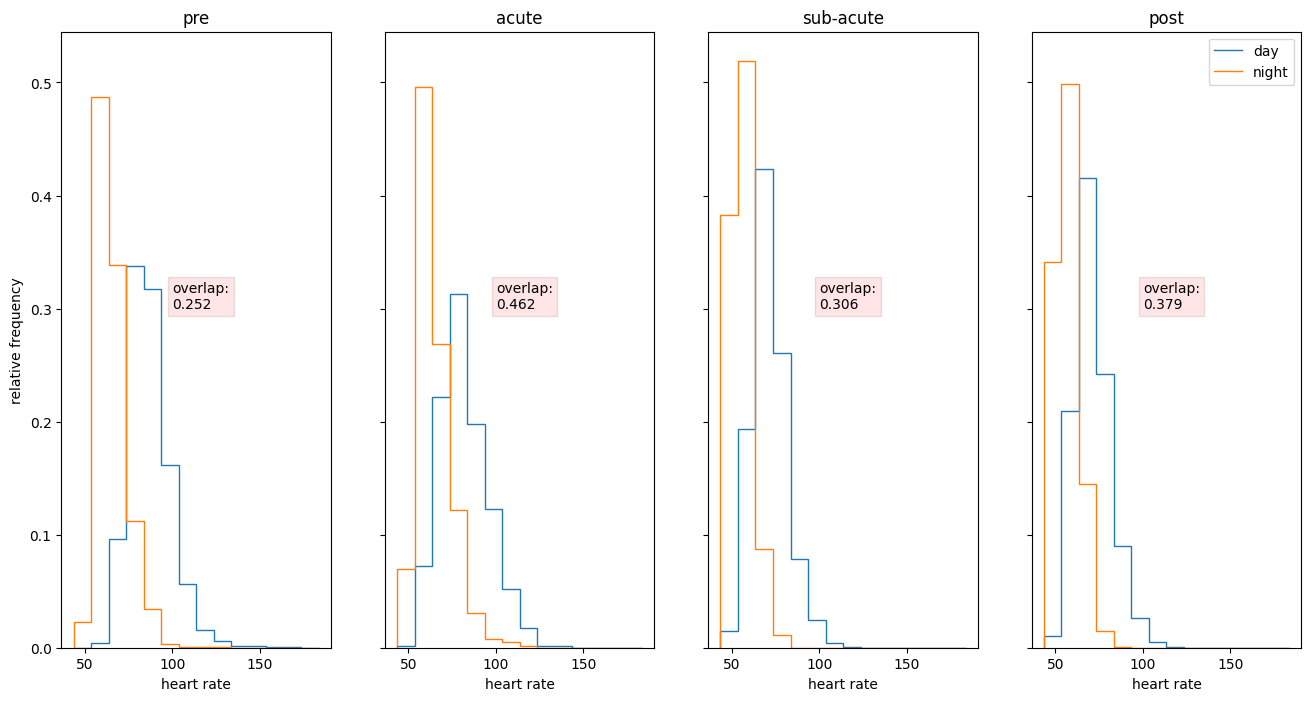

In [17]:
fig, ax = plt.subplots(1,4, figsize=(16,8), sharey=True, sharex = True)
phases = ['pre', 'acute', 'sub-acute', 'post']
for ph in [0,1,2,3]:
     
    dfph = df[df['phase'] == ph]
    
    
    n_a,_  = np.histogram(dfph[(dfph['time'] >= 29)&(dfph['steps'].notna())]['hr'].dropna(), bins=bins)
    ax[ph].stairs(n_a/len(dfph[(dfph['time'] >= 29)&(dfph['steps'].notna())]['hr'].dropna()), bins , fill=False)
    n_s = np.histogram(dfph[(dfph['time'] < 29)&(dfph['steps'].isna())]['hr'].dropna(), bins = bins)[0]
    ax[ph].stairs(n_s/len(dfph[(dfph['time'] < 29)&(dfph['steps'].isna())]['hr'].dropna()), bins, fill=False)
    A = n_a/len(dfph[(dfph['time'] >= 29)&(dfph['steps'].notna())]['hr'].dropna())
    B = n_s/len(dfph[(dfph['time'] < 29)&(dfph['steps'].isna())]['hr'].dropna())
    A = n_a/len(dfph[(dfph['time'] >= 29)&(dfph['steps'].notna())]['hr'].dropna())
    B = n_s/len(dfph[(dfph['time'] < 29)&(dfph['steps'].isna())]['hr'].dropna())
    ov = np.sum(np.minimum(A,B))
    ax[ph].text(100, 0.3, r'overlap:'+'\n'+str(np.round(ov,3)),
        bbox={'facecolor': 'red', 'alpha': 0.1, 'pad': 3})
    ax[ph].set_title(phases[ph])
    ax[ph].set_xlabel('heart rate');
ax[0].set_ylabel('relative frequency');
plt.legend(['day', 'night']);

## w new df

In [19]:
df = pd.read_csv('user_epoch/female50.023542.csv', index_col=0)

In [29]:
df2 = pd.read_csv('user_df/female50.023542.csv', index_col = 0)

In [45]:
df2[df2['date']=='2022-12-10']

,date,Time Bin 1,steps,hr,sleep,day_of_week,weekend,dt,week_totest,time,phase,d to max hr [%]
67392,2022-12-10,"[0, 1)",NaN,NaN,NaN,5,True,2022-03-18,39,0,3,NaN
67393,2022-12-10,"[1, 2)",NaN,NaN,NaN,5,True,2022-03-18,39,1,3,NaN
67394,2022-12-10,"[2, 3)",NaN,NaN,1.0,5,True,2022-03-18,39,2,3,NaN
67395,2022-12-10,"[3, 4)",NaN,NaN,1.0,5,True,2022-03-18,39,3,3,NaN
67396,2022-12-10,"[4, 5)",NaN,NaN,1.0,5,True,2022-03-18,39,4,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
67483,2022-12-10,"[91, 92)",NaN,NaN,1.0,5,True,2022-03-18,39,91,3,NaN
67484,2022-12-10,"[92, 93)",NaN,NaN,1.0,5,True,2022-03-18,39,92,3,NaN
67485,2022-12-10,"[93, 94)",NaN,NaN,1.0,5,True,2022-03-18,39,93,3,NaN
67486,2022-12-10,"[94, 95)",NaN,NaN,1.0,5,True,2022-03-18,39,94,3,NaN


In [41]:
df = df.sort_values(by='start')

In [46]:
df[df['date'] == '2022-12-09']

,start,hr,source,id,rhr,sleep,steps,date,day_of_week,weekend,dt,day_totest,week_totest,phase,% of MHR
23442,2022-12-09 00:00:00,NaN,NaN,NaN,NaN,1.0,0.0,2022-12-09,4,False,2022-03-18,266 days,38,3,NaN
23443,2022-12-09 00:15:00,NaN,NaN,NaN,NaN,1.0,0.0,2022-12-09,4,False,2022-03-18,266 days,38,3,NaN
23444,2022-12-09 00:30:00,NaN,NaN,NaN,NaN,1.0,0.0,2022-12-09,4,False,2022-03-18,266 days,38,3,NaN
23445,2022-12-09 00:45:00,NaN,NaN,NaN,NaN,1.0,0.0,2022-12-09,4,False,2022-03-18,266 days,38,3,NaN
23446,2022-12-09 01:00:00,NaN,NaN,NaN,NaN,1.0,0.0,2022-12-09,4,False,2022-03-18,266 days,38,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23464,2022-12-09 22:45:00,NaN,NaN,NaN,NaN,1.0,0.0,2022-12-09,4,False,2022-03-18,266 days,38,3,NaN
23465,2022-12-09 23:00:00,NaN,NaN,NaN,NaN,1.0,0.0,2022-12-09,4,False,2022-03-18,266 days,38,3,NaN
23466,2022-12-09 23:15:00,NaN,NaN,NaN,NaN,1.0,0.0,2022-12-09,4,False,2022-03-18,266 days,38,3,NaN
23467,2022-12-09 23:30:00,NaN,NaN,NaN,NaN,1.0,0.0,2022-12-09,4,False,2022-03-18,266 days,38,3,NaN


In [47]:
def get_ov(subd, bins):
    n_th = pd.to_datetime('1970-01-01 07:00:00').time()
    night = subd[(pd.to_datetime(subd['start']).dt.time < n_th)&((subd['steps'].isna())|(subd['steps'] == 0))]['hr'].dropna()
    day = subd[(pd.to_datetime(subd['start']).dt.time >= n_th)&((subd['steps'].isna())|(subd['steps'] != 0)) ]['hr'].dropna()
    n_d, _ = np.histogram(day, bins=bins)
    n_n, _ = np.histogram(night, bins=bins)
    d = n_d/len(day)
    n = n_n/len(night)
    
    return np.sum(np.minimum(n,d))

In [48]:
binwidth = 15
bins=np.linspace(df['hr'].min(), df['hr'].max() + (binwidth/2), binwidth)
wi_list = sliding_window(df['date'].unique(),21)
ovs = []
for wi in wi_list:
    ovs.append(get_ov(df[df['date'].isin(wi)], bins))

/tmp/ipykernel_71/2028428093.py:8: RuntimeWarning: invalid value encountered in divide
  n = n_n/len(night)
/tmp/ipykernel_71/2028428093.py:8: RuntimeWarning: invalid value encountered in divide
  n = n_n/len(night)
/tmp/ipykernel_71/2028428093.py:8: RuntimeWarning: invalid value encountered in divide
  n = n_n/len(night)
/tmp/ipykernel_71/2028428093.py:8: RuntimeWarning: invalid value encountered in divide
  n = n_n/len(night)
/tmp/ipykernel_71/2028428093.py:8: RuntimeWarning: invalid value encountered in divide
  n = n_n/len(night)
/tmp/ipykernel_71/2028428093.py:8: RuntimeWarning: invalid value encountered in divide
  n = n_n/len(night)
/tmp/ipykernel_71/2028428093.py:7: RuntimeWarning: invalid value encountered in divide
  d = n_d/len(day)
/tmp/ipykernel_71/2028428093.py:8: RuntimeWarning: invalid value encountered in divide
  n = n_n/len(night)
/tmp/ipykernel_71/2028428093.py:7: RuntimeWarning: invalid value encountered in divide
  d = n_d/len(day)
/tmp/ipykernel_71/2028428093.py: